In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import  train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score


random_state = 42

#display notebook in full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [38]:
TARGET = 'Response'

In [39]:
def column_properties(df):
    columns_prop = pd.DataFrame()
    columns_prop['column'] = df.columns.tolist()
    columns_prop['count_non_null'] = df.count().values
    columns_prop['count_null'] = df.isnull().sum().values
    columns_prop['perc_null'] = columns_prop['count_null'] * 100 / df.shape[0]

    #using df.nunique() is memory intensive and slow resulting in kernal death
    unique_list = []
    for col in df.columns.tolist():
        unique_list.append(df[col].value_counts().shape[0])
    columns_prop['count_unique'] =  unique_list
    
    columns_prop['dtype'] = df.dtypes.values
    columns_prop.set_index('column', inplace = True)
    return columns_prop

### Read data

In [40]:
data_path = "C:\\Users\\I056036\\OneDrive - SAP SE\\Documents\\Docs\\Development\\datasets\\AV VehicleInsurance\\data"
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))

print('Train  Data - rows:', train.shape[0], 'columns:', train.shape[1])
print('Test  Data - rows:', test.shape[0], 'columns:', test.shape[1])

Train  Data - rows: 381109 columns: 12
Test  Data - rows: 127037 columns: 11


### Training Data

In [41]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [42]:
column_properties(train)

,count_non_null,count_null,perc_null,count_unique,dtype
column,,,,,
id,381109,0,0.0,381109,int64
Gender,381109,0,0.0,2,object
Age,381109,0,0.0,66,int64
Driving_License,381109,0,0.0,2,int64
Region_Code,381109,0,0.0,53,float64
Previously_Insured,381109,0,0.0,2,int64
Vehicle_Age,381109,0,0.0,3,object
Vehicle_Damage,381109,0,0.0,2,object
Annual_Premium,381109,0,0.0,48838,float64


## Test Data

In [43]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [44]:
column_properties(test)

,count_non_null,count_null,perc_null,count_unique,dtype
column,,,,,
id,127037,0,0.0,127037,int64
Gender,127037,0,0.0,2,object
Age,127037,0,0.0,66,int64
Driving_License,127037,0,0.0,2,int64
Region_Code,127037,0,0.0,53,float64
Previously_Insured,127037,0,0.0,2,int64
Vehicle_Age,127037,0,0.0,3,object
Vehicle_Damage,127037,0,0.0,2,object
Annual_Premium,127037,0,0.0,36327,float64


## TARGET 

,count,percent
Response,,
0,334399,87.74
1,46710,12.26


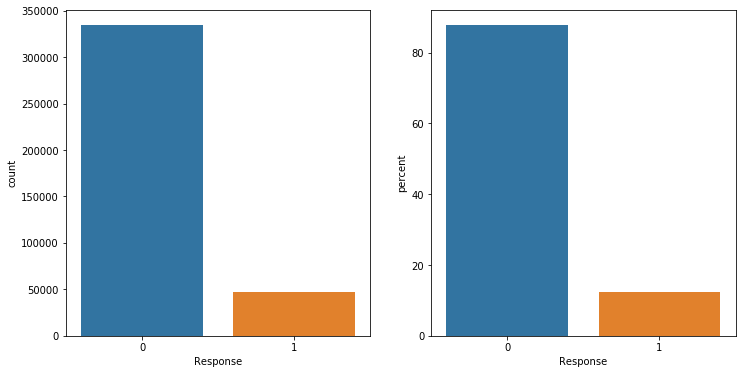

In [45]:
df = train.groupby(TARGET).agg({TARGET:['count'] })
df.columns = ['count']
df['percent'] = df['count'] *100 / df['count'].sum()
df['percent'] = df['percent'].round(2)

fig, (ax1, ax2)  =  plt.subplots(ncols = 2, figsize = (12, 6))
s = sns.barplot(ax = ax1, x = df.index, y = "count", data = df)
s = sns.barplot(ax = ax2, x = df.index, y = "percent", data = df)
df

## Plot Categorical Features 

In [46]:
cols = train.columns.tolist()
categorical_cols = [ 'Gender',  'Driving_License', 'Region_Code', 'Previously_Insured',  'Vehicle_Damage',  'Policy_Sales_Channel',  'Vehicle_Age']
numerical_cols = ['Age',   'Annual_Premium', 'Vintage']

In [47]:

def plot_categorical_cols(col, data, top_n = 10, display_data = False ):
    df_data = data[[col, TARGET]].copy()    
    df = df_data.groupby(col).agg({col:['count'], TARGET:['sum']})
    df.columns = ['count', 'purchase_count']

    df['purchase_perc'] = df['purchase_count'] * 100 / df['count']
    df['purchase_perc'] = df['purchase_perc'].round(2)

    width = 18
    height = 6

    if top_n < 8:
         height = 4
    elif top_n < 15:
         height = 6
    elif top_n < 50:
         height = 8

    df_disp = df.sort_values(by ='count', ascending= False).head(top_n )

    fig, (ax1, ax2)  =  plt.subplots(ncols = 2, figsize = (width,height))

    plot_order = df_disp.sort_values(by='count', ascending=False).index.values

    s = sns.barplot(ax = ax1,  y = df_disp.index, x = df_disp['count'], order=plot_order, orient = 'h'  )
    s.set_title('Count for {}'.format(col))

    s = sns.barplot(ax = ax2,  y = df_disp.index, x = df_disp['purchase_perc'], order=plot_order , orient = 'h'    )
    s.set(xlabel='Percent of purchases')
    s.set_title('% purchases for {}'.format(col))
    plt.show()
    if display_data:
        return df

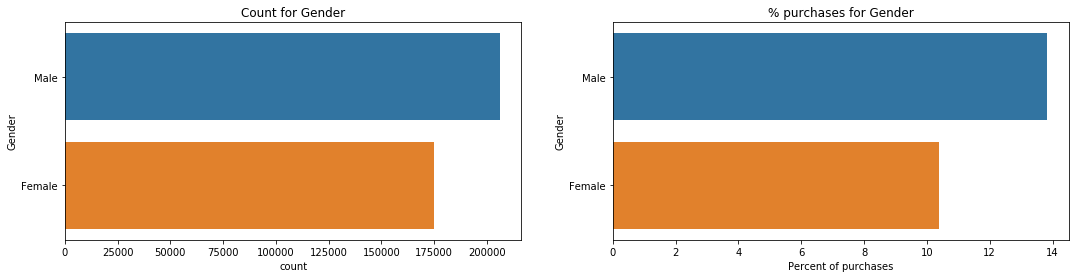

In [48]:
plot_categorical_cols('Gender', train, top_n = 2 )

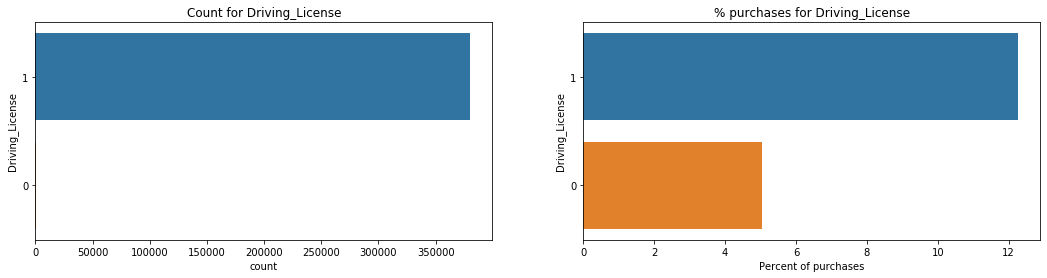

,count,purchase_count,purchase_perc
Driving_License,,,
0,812,41,5.05
1,380297,46669,12.27


In [49]:
plot_categorical_cols('Driving_License', train, top_n = 2, display_data = True )

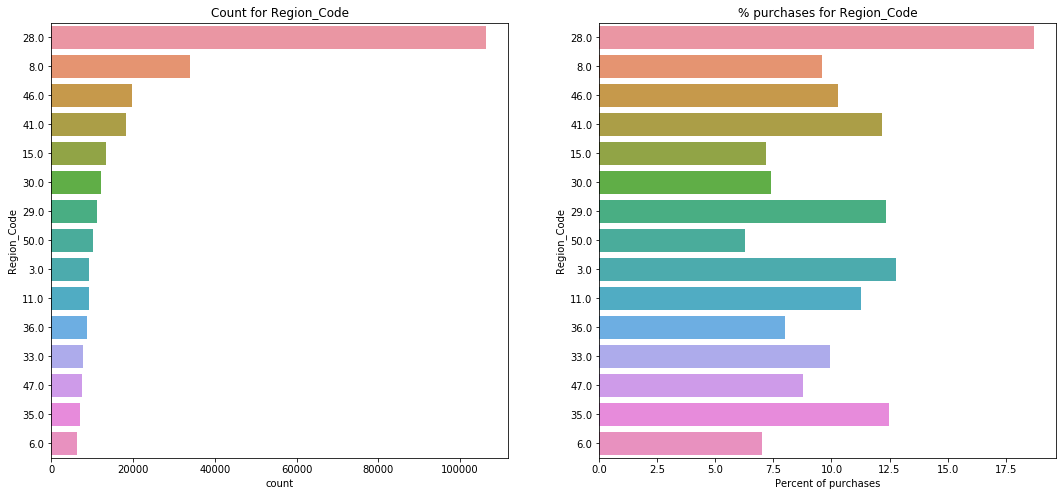

In [50]:
plot_categorical_cols('Region_Code', train, top_n = 15 )

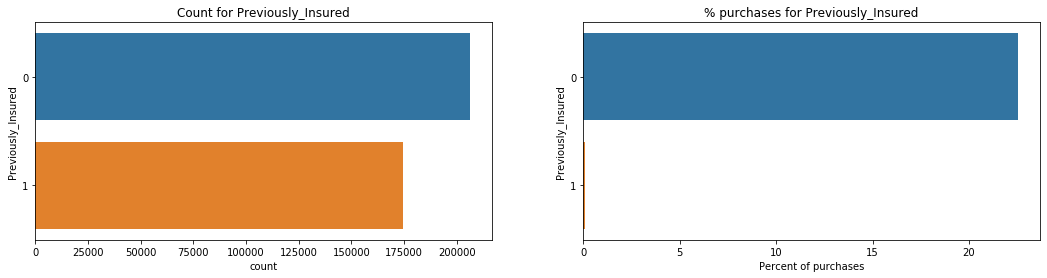

,count,purchase_count,purchase_perc
Previously_Insured,,,
0,206481,46552,22.55
1,174628,158,0.09


In [51]:
plot_categorical_cols('Previously_Insured', train, top_n = 2,display_data = True )

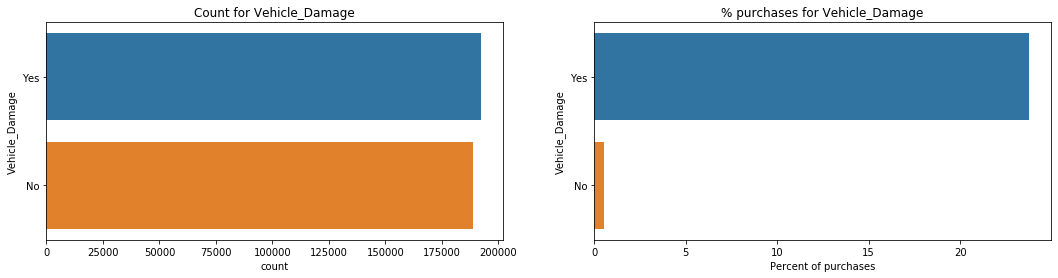

,count,purchase_count,purchase_perc
Vehicle_Damage,,,
No,188696,982,0.52
Yes,192413,45728,23.77


In [52]:
plot_categorical_cols('Vehicle_Damage', train, top_n = 2,display_data = True )

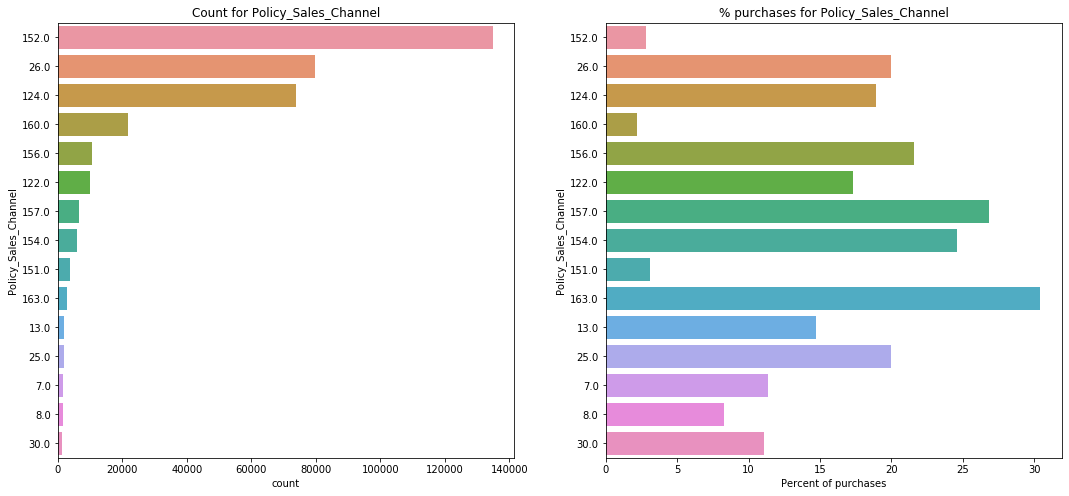

In [53]:
plot_categorical_cols('Policy_Sales_Channel', train, top_n = 15,display_data = False )

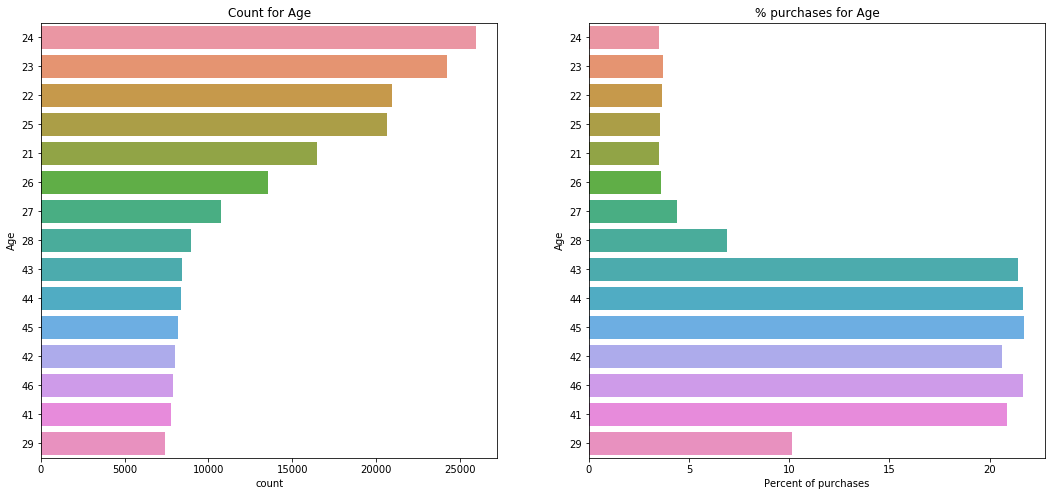

In [54]:
plot_categorical_cols('Age', train, top_n = 15,display_data = False )

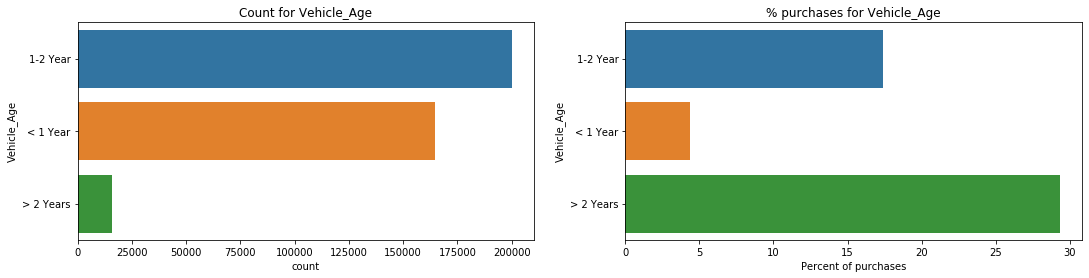

In [55]:
plot_categorical_cols('Vehicle_Age', train, top_n = 3,display_data = False )

## Plot Continuous Features

In [56]:
def plot_continious_features(df, col, target_col, remove_outliers = False):   
    
    df = df[[col, target_col]].copy()
    df.dropna(subset=[col], inplace =True)
   
    if remove_outliers:       
        #Remove Outliers: keep only the ones that are within +3 to -3 standard deviations in the column 
        df = df[np.abs(df[col]-df[col].mean()) <= (3*df[col].std())]       

    fig = plt.figure(figsize=(24, 4)) 
    #Display Density Plot
    sns.distplot(df[col], color = 'b',  kde = True ,  ax =plt.subplot(131) )
    plt.ylabel('Density')

    #   Display Box Plot for feature
    sns.boxplot(x = col , data = df,ax =plt.subplot(132))
   

    sns.distplot(df[df[target_col] == 0][col], color = 'b',  kde = True, label = 'Did Not Purchase',ax = plt.subplot(133))
    sns.distplot(df[df[target_col] == 1][col], color = 'r', kde = True,label = 'Purchased',ax = plt.subplot(133))
    plt.legend(loc = 'best')
    plt.ylabel('Density Purchased vs not Purchased')

    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


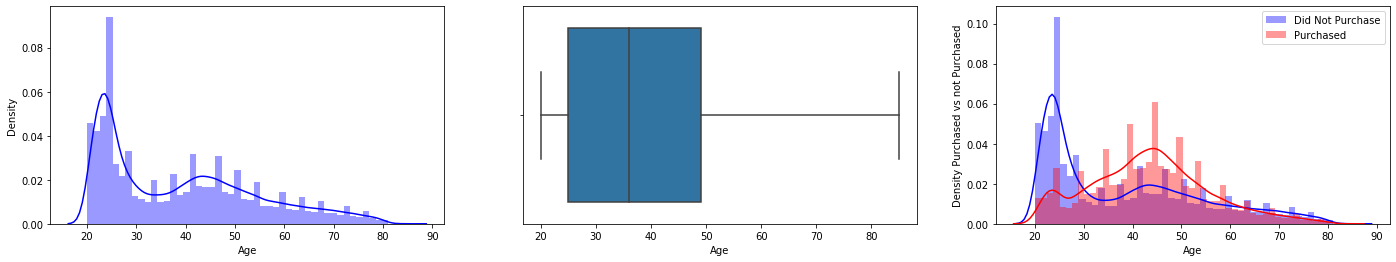

In [57]:
plot_continious_features(train, 'Age', TARGET, remove_outliers = False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


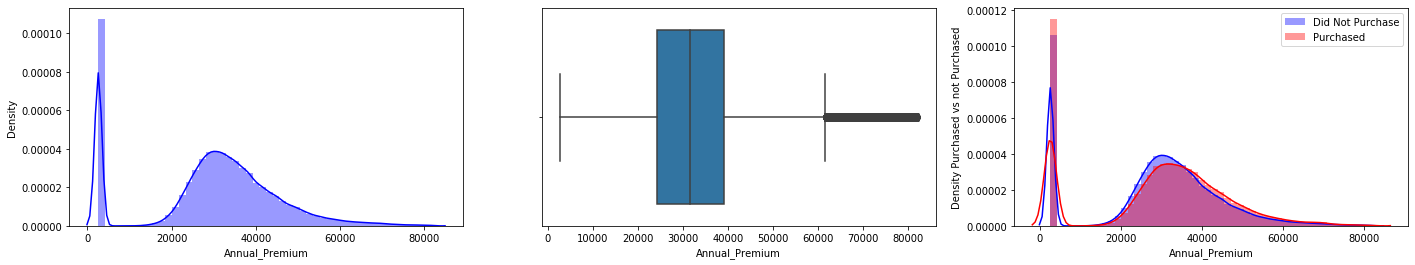

In [58]:
plot_continious_features(train, 'Annual_Premium', TARGET, remove_outliers = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


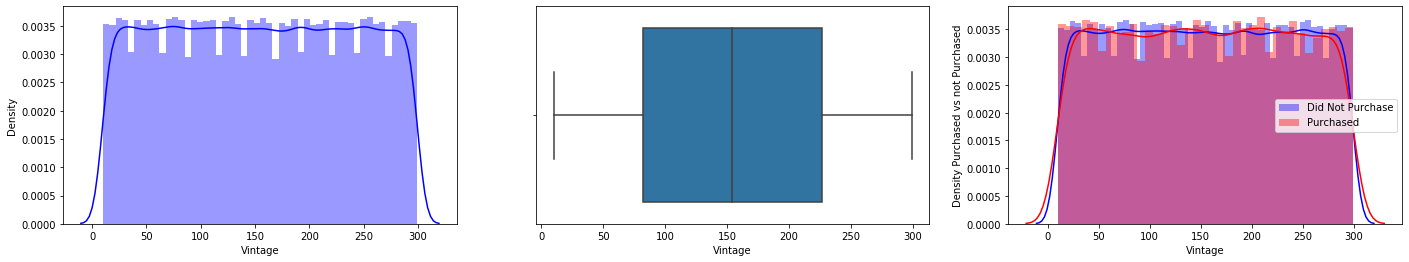

In [59]:
plot_continious_features(train, 'Vintage', TARGET, remove_outliers = False)

In [82]:
def set_ordinal_encoding(data, cat_cols):       
    for col in [x for x in cat_cols if data[x].dtype == 'object']:
#     for col in cat_cols:
        data[col], uniques = pd.factorize(data[col])
        #the factorize sets null values to -1, so convert them back to null, as we want LGB to handle null values
        data[col] = data[col].replace(-1, np.nan)
    print('Finished: Ordinal Encoding')
    return data

def run_lgb_with_cv(params, X_train, y_train, X_test,cat_cols,  test_size =0.2, verbose_eval = 100, early_stopping_rounds = 200 ):
    
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = test_size , 
                                                              random_state = random_state, stratify = y_train)
   
  
    print('Train shape{} Valid Shape{}, Test Shape {}'.format(X_train.shape, X_valid.shape, X_test.shape))
    print('Number of Category Columns {}:'.format(len(cat_cols)))

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid  = lgb.Dataset(X_valid, y_valid)
#     early_stopping_rounds = 2000
    lgb_results = {}    

#     warnings.filterwarnings("ignore", message="categorical_feature in Dataset is overridden")
#     warnings.filterwarnings("ignore", message="F-score is ill-defined and being set to 0.0 due to no predicted samples")
    
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round = 10000,
                      valid_sets =  [lgb_train,lgb_valid],  #Including train set will do early stopiing for train instead of validation
                      early_stopping_rounds = early_stopping_rounds,                      
                      categorical_feature = cat_cols,
                      evals_result = lgb_results,
#                       feval = lgb_f1_score,
                      verbose_eval = verbose_eval
                       )
    y_prob_valid = model.predict(X_valid)    
    cv_results(y_valid, y_prob_valid, verbose = True)
  
    feature_imp = pd.DataFrame()
    feature_imp['feature'] = model.feature_name()
    feature_imp['importance']  = model.feature_importance()
    feature_imp = feature_imp.sort_values(by = 'importance', ascending= False )
    return model, feature_imp, lgb_results

def cv_results(y_valid, y_prob, verbose = True):   
    scores = {}                      
    y_pred_class =  [0  if x < 0.5 else 1 for x in y_prob]
    scores['cv_accuracy']  = accuracy_score(y_valid, y_pred_class)
    scores['cv_auc']       = roc_auc_score(y_valid, y_prob)
    scores['cv_f1']      =   f1_score(y_valid, y_pred_class, average = 'binary')
    if verbose:
        print('CV accuracy {:0.6f}'.format( scores['cv_accuracy'] ))
        print('CV AUC  {:0.6f}'.format( scores['cv_auc']   ))
        print('CV F1 %0.6f' %scores['cv_f1'] )
    return scores

def plot_feature_imp(feature_imp, top_n = 30):
    feature_imp = feature_imp.sort_values(['importance'], ascending = False)
    feature_imp_disp = feature_imp.head(top_n)
    plt.figure(figsize=(10, 12))
    sns.barplot(x="importance", y="feature", data=feature_imp_disp)
    plt.title('LightGBM Features')
    plt.show() 
    
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_pred =  [0  if x < 0.5 else 1 for x in y_hat]
#     y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_pred), True
 
def plot_scores(lgb_results):
    train_res = lgb_results['training']['auc']
    valid_res = lgb_results['valid_1']['auc']
    niter = range(1, len(train_res) + 1)

    plt.figure(figsize = (12, 6))
    plt.plot(niter, train_res , 'b', label = 'Training')
    plt.plot(niter, valid_res, 'r', label = 'Validation')
    plt.xlabel('Iteration', fontsize = 14)
    plt.ylabel('AUC Score', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.title('Training VS Validation AUC')
    plt.show()

In [83]:
features = categorical_cols + numerical_cols
X_train = train[features]
y_train = train[TARGET]
X_test =  test[features]

X_train = set_ordinal_encoding(X_train, categorical_cols)

Finished: Ordinal Encoding


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [135]:
%%time
params = {}
params['learning_rate'] = 0.05
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['seed'] =  random_state
params['metric'] = 'auc'
# params['lambda_l2'] = 10
params['num_leaves'] =  128
# params['scale_pos_weight'] = 4

# cat_cols = [ 'Gender',  'Driving_License', 'Region_Code', 'Previously_Insured',  'Vehicle_Damage',   'Vehicle_Age']
cat_cols = categorical_cols
model, feature_imp, lgb_results =  run_lgb_with_cv(params, X_train, y_train, X_test, cat_cols= cat_cols, verbose_eval = 100, early_stopping_rounds = 500) 

Train shape(304887, 10) Valid Shape(76222, 10), Test Shape (127037, 10)
Number of Category Columns 7:


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 37368, number of negative: 267519
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122563 -> initscore=-1.968376
[LightGBM] [Info] Start training from score -1.968376
Training until validation scores don't improve for 500 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's auc: 0.880178	valid_1's auc: 0.857376
[200]	training's auc: 0.891042	valid_1's auc: 0.857125
[300]	training's auc: 0.903962	valid_1's auc: 0.856447
[400]	training's auc: 0.914707	valid_1's auc: 0.855417
[500]	training's auc: 0.923263	valid_1's auc: 0.854729
Early stopping, best iteration is:
[96]	training's auc: 0.879684	valid_1's auc: 0.857443
CV accuracy 0.877188
CV AUC  0.857443
CV F1 0.019893
Wall time: 19.5 s


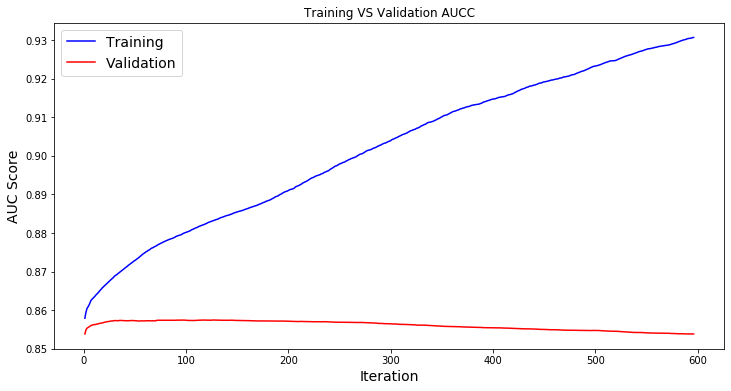

In [136]:

plot_scores(lgb_results)

In [123]:
print(model.params)

{'learning_rate': 0.05, 'boosting_type': 'gbdt', 'objective': 'binary', 'seed': 42, 'metric': 'auc', 'lambda_l2': 10, 'num_leaves': 4, 'num_iterations': 10000, 'early_stopping_round': 500, 'categorical_column': [0, 1, 2, 3, 4, 6]}
